# Application: Classification transaction bancaire

## Introduction

Dans ce tutoriel, nous allons explorer un exemple concret de classification binaire dans le domaine financier. Un exemple de la détection de fraude par carte de crédit. Nous utiliserons la régression logistique, pour prédire si une transaction est frauduleuse ou non.

Commençons par charger les bibliothèques nécessaires :

In [2]:
library(tidyverse)  # Pour la manipulation et visualisation des données
library(caret)      # Pour la préparation des données et l'évaluation du modèle
library(pROC)       # Pour la courbe ROC

set.seed(3035)

## 1. Génération de données synthétiques

Dans un cas réel, nous utiliserions des données historiques de transactions. Pour ce tutoriel, nous allons générer des données que nous créons qui simulent des transactions par carte de crédit.

In [3]:
generer_normales <- function(n) {
  tibble(
    montant = rlnorm(n, meanlog = 4, sdlog = 1),
    heure = sample(0:23, n, replace = TRUE),
    jour_semaine = sample(1:7, n, replace = TRUE),
    age_compte = runif(n, 0, 3650),
    fraude = 0
  )
}

In [4]:
generer_frauduleuses <- function(n) {
  tibble(
    montant = rlnorm(n, meanlog = 5, sdlog = 1.5),
    heure = sample(0:23, n, replace = TRUE, prob = c(rep(1, 6), rep(3, 18))),
    jour_semaine = sample(1:7, n, replace = TRUE),
    age_compte = runif(n, 0, 365),
    fraude = 1
  )
}


In [5]:
n <- 10000  # nombre total de transactions
donnees_normales <- generer_normales(n * 0.99)  # 99% de transactions normales
donnees_frauduleuses <- generer_frauduleuses(n * 0.01)  # 1% de transactions frauduleuses
donnees <- bind_rows(donnees_normales, donnees_frauduleuses)


In [6]:
head(donnees)

montant   heure jour_semaine age_compte fraude
1  24.45815  1    6            2375.5742  0     
2  74.17737 18    7            1326.5493  0     
3  51.12859 12    7            1245.7210  0     
4 220.46457  4    4              77.3116  0     
5 113.68081  1    7            1917.0361  0     
6  18.25704 18    3            3307.5299  0

In [26]:
write.csv(donnees, "fraud_Cc.csv", row.names=F)

## 2. Exploration des données

In [7]:
summary(donnees)

    montant             heure        jour_semaine     age_compte      
 Min.   :   1.376   Min.   : 0.00   Min.   :1.000   Min.   :   0.138  
 1st Qu.:  28.026   1st Qu.: 5.00   1st Qu.:2.000   1st Qu.: 919.926  
 Median :  56.426   Median :11.00   Median :4.000   Median :1833.957  
 Mean   :  93.171   Mean   :11.46   Mean   :3.991   Mean   :1823.207  
 3rd Qu.: 109.311   3rd Qu.:17.00   3rd Qu.:6.000   3rd Qu.:2744.068  
 Max.   :2428.218   Max.   :23.00   Max.   :7.000   Max.   :3648.681  
     fraude    
 Min.   :0.00  
 1st Qu.:0.00  
 Median :0.00  
 Mean   :0.01  
 3rd Qu.:0.00  
 Max.   :1.00  

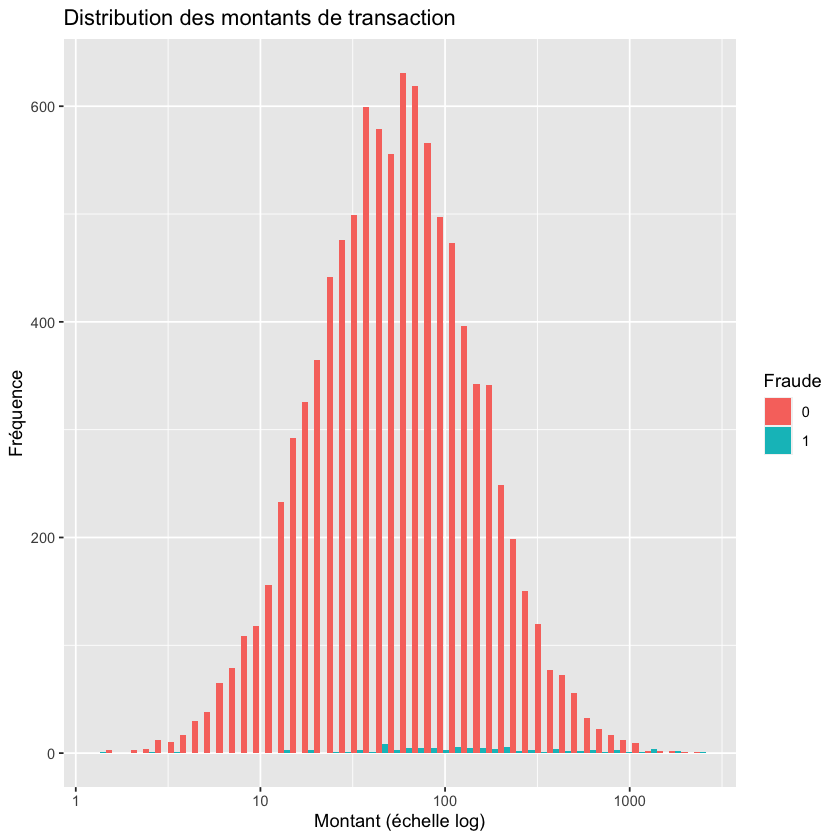

In [8]:
ggplot(donnees, aes(x = montant, fill = factor(fraude))) +
  geom_histogram(bins = 50, position = "dodge") +
  scale_x_log10() +
  labs(title = "Distribution des montants de transaction", 
       x = "Montant (échelle log)", y = "Fréquence", fill = "Fraude")

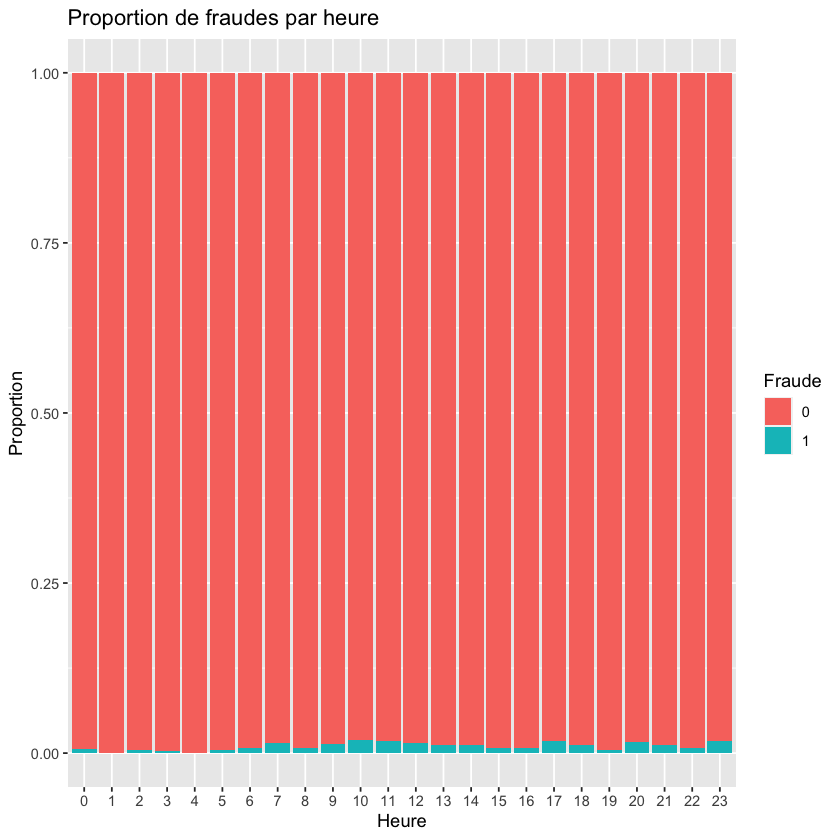

In [9]:
ggplot(donnees, aes(x = factor(heure), fill = factor(fraude))) +
  geom_bar(position = "fill") +
  labs(title = "Proportion de fraudes par heure", 
       x = "Heure", y = "Proportion", fill = "Fraude")

## 3. Prétraitement des données

Préparons nos données pour la modélisation :

In [10]:
# Conversion de 'fraude' en facteur afin de rendre ces variable catégorielles
donnees$fraude <- as.factor(donnees$fraude)

In [11]:
# Normalisation des variables numériques
preprocess_params <- preProcess(donnees %>% select(-fraude), method = c("center", "scale"))
donnees_normalisees <- predict(preprocess_params, donnees)

In [12]:
# Division en ensembles d'entraînement et de test
indices_partition <- createDataPartition(donnees_normalisees$fraude, p = 0.8, list = FALSE)
donnees_train <- donnees_normalisees[indices_partition, ]
donnees_test <- donnees_normalisees[-indices_partition, ]

In [27]:
write.csv(donnees_train, "donnees_train_Cc.csv", row.names=F)
write.csv(donnees_test, "donnees_test_Cc.csv", row.names=F)

In [13]:
print(paste("Dimensions de l'ensemble d'entraînement :", paste(dim(donnees_train), collapse = " x ")))
print(paste("Dimensions de l'ensemble de test :", paste(dim(donnees_test), collapse = " x ")))

[1] "Dimensions de l'ensemble d'entraînement : 8000 x 5"
[1] "Dimensions de l'ensemble de test : 2000 x 5"


## 4. Construction du modèle de régression logistique

In [14]:
modele_log <- glm(fraude ~ ., data = donnees_train, family = binomial())
summary(modele_log)


Call:
glm(formula = fraude ~ ., family = binomial(), data = donnees_train)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -10.71128    0.93335 -11.476  < 2e-16 ***
montant        0.46174    0.06210   7.435 1.04e-13 ***
heure          0.37870    0.13171   2.875  0.00404 ** 
jour_semaine  -0.08803    0.12449  -0.707  0.47948    
age_compte    -5.08255    0.60575  -8.390  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 896.02  on 7999  degrees of freedom
Residual deviance: 536.62  on 7995  degrees of freedom
AIC: 546.62

Number of Fisher Scoring iterations: 11


## 5. Évaluation du modèle

Évaluons la performance de notre modèle :

In [16]:
predictions_prob <- predict(modele_log, newdata = donnees_test, type = "response")
predictions_classe <- ifelse(predictions_prob > 0.5, 1, 0)

In [17]:
# Matrice de confusion
matrice_confusion <- confusionMatrix(factor(predictions_classe), donnees_test$fraude)
print(matrice_confusion)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1979   17
         1    1    3
                                          
               Accuracy : 0.991           
                 95% CI : (0.9858, 0.9947)
    No Information Rate : 0.99            
    P-Value [Acc > NIR] : 0.380573        
                                          
                  Kappa : 0.2475          
                                          
 Mcnemar's Test P-Value : 0.000407        
                                          
            Sensitivity : 0.9995          
            Specificity : 0.1500          
         Pos Pred Value : 0.9915          
         Neg Pred Value : 0.7500          
             Prevalence : 0.9900          
         Detection Rate : 0.9895          
   Detection Prevalence : 0.9980          
      Balanced Accuracy : 0.5747          
                                          
       'Positive' Class : 0               
                        

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC : 0.968156565656562"


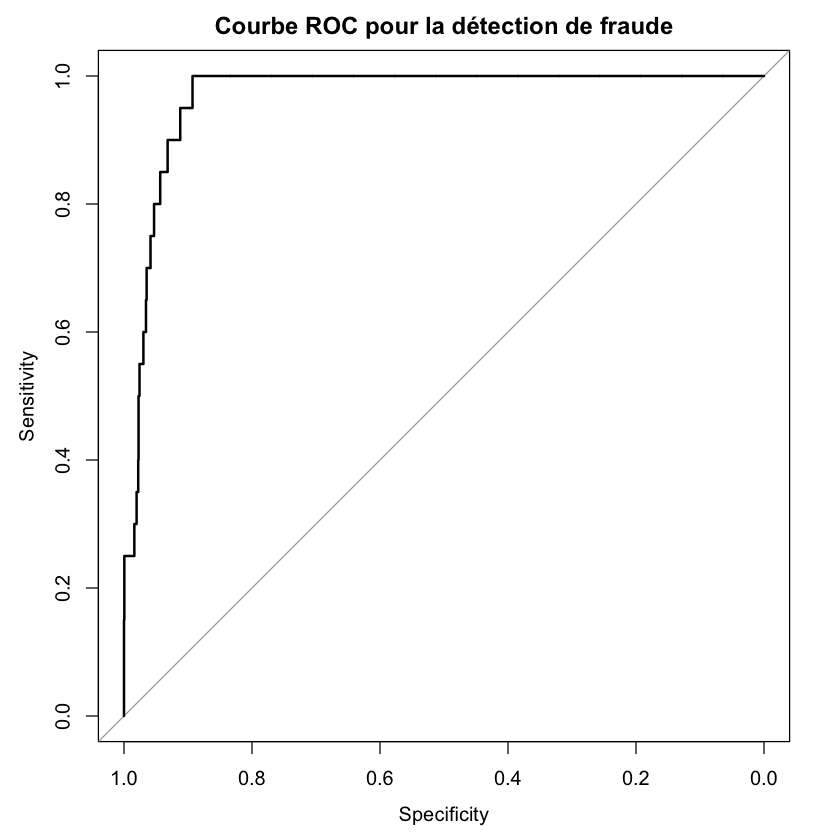

In [18]:
# Courbe ROC
courbe_roc <- roc(donnees_test$fraude, predictions_prob)
plot(courbe_roc, main = "Courbe ROC pour la détection de fraude")
print(paste("AUC :", auc(courbe_roc)))

## 6. Prédiction sur de nouvelles données

Utilisons notre modèle pour prédire la probabilité de fraude pour une nouvelle transaction :

In [20]:
nouvelle_transaction <- tibble(
  montant = 1000,
  heure = 14,
  jour_semaine = 3,
  age_compte = 730
)

In [21]:
# Normalisation de la nouvelle transaction
nouvelle_transaction_norm <- predict(preprocess_params, nouvelle_transaction)

In [22]:
# Prédiction
proba_fraude <- predict(modele_log, nouvelle_transaction_norm, type = "response")
print(paste("Probabilité de fraude pour la nouvelle transaction :", round(proba_fraude, 4)))

[1] "Probabilité de fraude pour la nouvelle transaction : 0.1224"


## Conclusion

Dans ce tutoriel, nous avons construit un modèle de régression logistique pour détecter les fraudes par carte de crédit. Voici les points clés à retenir :

1. La préparation et l'exploration des données sont cruciales avant la modélisation.
2. La régression logistique est un outil puissant pour la classification binaire.
3. L'évaluation du modèle implique plusieurs métriques, dont la matrice de confusion et la courbe ROC.
4. L'interprétation des coefficients nous donne des insights sur l'importance des variables.
5. Le modèle peut être utilisé pour prédire la probabilité de fraude sur de nouvelles transactions.

Dans un contexte réel, ce modèle pourrait être utilisé comme un système d'alerte précoce, identifiant les transactions à haut risque pour une vérification plus approfondie.

# Exercices 

Ces exercices sont conçus pour renforcer votre compréhension de la classification binaire en utilisant R, en s'appuyant sur l'exemple de détection de fraude par carte de crédit.

## Exercice 1 : Exploration et visualisation des données

Objectif : Approfondir l'analyse exploratoire des données.

a) Créez un graphique montrant la relation entre l'âge du compte et le montant de la transaction, coloré par le statut de fraude.

b) Calculez et affichez le pourcentage de transactions frauduleuses par jour de la semaine. Quel jour semble avoir le plus haut taux de fraude ?

In [ ]:
ggplot(donnees, aes(x = age_compte, y = montant, color = factor(fraude))) +
  geom_point(alpha = 0.5) +
  scale_y_log10() +
  labs(title = "Âge du compte vs Montant de la transaction", 
       x = "Âge du compte (jours)", y = "Montant (échelle log)", color = "Fraude")

In [ ]:
donnees %>%
  group_by(jour_semaine) %>%
  summarise(taux_fraude = mean(fraude == 1) * 100) %>%
  arrange(desc(taux_fraude))

## Exercice 2 : Prétraitement des données

Objectif : Expérimenter avec différentes techniques de prétraitement.

a) Au lieu de normaliser les variables numériques, essayez de les standardiser (z-score). Comment cela affecte-t-il les résultats du modèle ?

b) Créez une nouvelle variable catégorielle 'periode_jour' basée sur l'heure (matin : 6-12, après-midi : 12-18, soir : 18-24, nuit : 0-6). Incluez cette nouvelle variable dans le modèle.

In [ ]:
# Standardisation
preprocess_params <- preProcess(donnees %>% select(-fraude), method = c("center", "scale"))
donnees_standardisees <- predict(preprocess_params, donnees)

In [ ]:
# Création de la variable 'periode_jour'
donnees <- donnees %>%
  mutate(periode_jour = case_when(
    heure >= 6 & heure < 12 ~ "matin",
    heure >= 12 & heure < 18 ~ "après-midi",
    heure >= 18 & heure < 24 ~ "soir",
    TRUE ~ "nuit"
  ))


## Exercice 3 : Gestion du déséquilibre des classes

Objectif : Comprendre l'impact du déséquilibre des classes sur le modèle.

a) Utilisez la technique de sous-échantillonnage pour équilibrer les classes dans l'ensemble d'entraînement. Comment cela affecte-t-il les performances du modèle ?

b) Expérimentez avec différents seuils de classification (au lieu de 0.5). Comment cela affecte-t-il la précision et le rappel du modèle ?

In [ ]:
donnees_equilibrees <- downSample(x = donnees_train[, -which(names(donnees_train) == "fraude")],
                                  y = donnees_train$fraude)

In [ ]:
# Différents seuils
seuils <- seq(0.1, 0.9, by = 0.1)
resultats <- data.frame()
for (seuil in seuils) {
  predictions_classe <- ifelse(predictions_prob > seuil, 1, 0)
  cm <- confusionMatrix(factor(predictions_classe), donnees_test$fraude)
  resultats <- rbind(resultats, data.frame(Seuil = seuil, 
                                           Precision = cm$byClass["Precision"],
                                           Rappel = cm$byClass["Recall"]))
}
print(resultats)